<a id='index'></a>
# Deterministic Single Site Simple Model 

* [Introduction](#intro)
* [Input data](#input_data)
* [Single objective problem 1](#so_problem)
* [Single objective problem 2](#so_problem_2)
* [Multi objective problem 1](#mo_problem)

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from datetime import datetime as dt

import numpy as np

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelweight'] = 'bold'

import plotly.offline as opy
import plotly.graph_objs as go
opy.init_notebook_mode()

import utils
from biopharma_scheduling.single_site.deterministic import DetSingleSiteSimple

In [16]:
utils.toggle_code() # Hides/Shows the code (input cells)

<a id='intro'></a>
## Introduction

`DetSingleSiteSimple` models a biopharmaceutical manufacturing facility with a 1:1 USP to DSP suite ratio. The product-dependent changeovers are implemented on a rolling basis (see the figures below).

![Rolling Changeovers 1](media/rolling_changeovers1.png)
![Rolling Changeovers 2](media/rolling_changeovers2.png)

The two figures above illustrate a rolling product changeover between the manufacturing campaigns of products A and C. Numbers inside the blocks denote the duration of the corresponding task while a gap between the different task blocks indicates a changeover is taking a place. For example, it takes fewer than 5 days to switch from product A Inoculation to product C Inoculation.

In [17]:
display(help(DetSingleSiteSimple))

Help on class DetSingleSiteSimple in module biopharma_scheduling.single_site.deterministic:

class DetSingleSiteSimple(builtins.object)
 |  Continuous-time capacity planning of a single multi-product
 |  biopharmaceutical facility using a Deterministic Single/Multi-Objective 
 |  Genetic Algorithm.
 |  
 |  See 'DetSingleSiteSimple.AVAILABLE_OBJECTIVES' for the objectives
 |  and constraints available in this model.
 |  
 |  Constraints take the priority over the objectives.
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      PARAMETERS:
 |      
 |          num_runs: int, default 10
 |              Number of times the genetic algorithm will be run with different seeds
 |              for the random number generator. The population is re-generated before 
 |              the start of each run.
 |      
 |          num_gens: int, default 1000
 |              Number of generations of the genetic algorithm for a single run.
 |      
 |          popsize: int, default 100
 |      

None

[back to top](#index)

<a id='input_data'></a>
## Input data

The `DetSingleSiteSimple` has 5 input data components:
 
* GA parameters set that is called by the `DetSingleSiteSimple` constructor.
* Schedule start date in the `%Y-%m-%d` format.
* Optimisation objectives - these must be selected from `DetSingleSiteSimple.AVAILABLE_OBJECTIVES`.
* Product data such as durations, costs, shelf-life limits etc.
* Product-dependent changeovers table - number of days it takes to switch from one product campaign to another. 
* Product demand - due dates for a specific kg amount of each product.
* Product inventory levels (optional) - desired kg amount of each product after demand is met at a given date
* Optimisation constraints (optional) - again, these must be selected from `DetSingleSiteSimple.AVAILABLE_OBJECTIVES`.

In [18]:
# How the input data is stored doesn't matter as long as Pandas DataFrames are used in the end
start_date = '2016-12-01'
kg_demand = pd.read_csv('data/deterministic_single_site_simple/kg_demand.csv', index_col='date')
kg_inventory_target = pd.read_csv('data/deterministic_single_site_simple/kg_inventory_target.csv', index_col='date')
product_data = pd.read_csv('data/deterministic_single_site_simple/product_data.csv')
changeover_days = pd.read_csv('data/deterministic_single_site_simple/changeover_days.csv')
    
# Product colors to display in the Gantt charts
colors = {
    'A': 'rgb(146, 208, 80)', 
    'B': 'rgb(179, 129, 217)', 
    'C': 'rgb(196, 189, 151)', 
    'D': 'rgb(255, 0, 0)'
}

utils.show(product_data.transpose(), header='<h3>Product data</h3>')
utils.show(changeover_days, header='<h3>Product-dependent changeover data [days]</h3>')
utils.show(kg_demand.transpose(), header='<h3>Product demand [kg]</h3>')
utils.show(kg_inventory_target.transpose(), header='<h3>Product inventory target [kg]</h3>')

utils.display(utils.HTML('<h3>Available Objectives</h3>'))
DetSingleSiteSimple.AVAILABLE_OBJECTIVES

0    1     2    3
product                               A    B     C    D
inoculation_days                     20   15    20   26
seed_days                            11    7    11    9
production_days                      14   14    14   14
usp_days                             45   36    45   49
dsp_days                              7   11     7    7
approval_days                        90   90    90   90
shelf_life_days                     730  730   730  730
kg_yield_per_batch                  3.1  6.2   4.9  5.5
kg_storage_limits                   250  250   250  250
kg_opening_stock                   18.6    0  19.6   32
min_batches_per_campaign              2    2     2    2
max_batches_per_campaign             50   50    50   30
batches_multiples_of_per_campaign     1    1     1    3
production_cost_per_kg                1    1     1    1
sell_price_per_kg                     1    1     1    1
inventory_penalty_per_kg              1    1     1    1
backlog_penalty_per_kg                1    1     1    1
storage_cost_per_kg                   1    1     1    1
waste_cost_per_kg                     1    1     1    1

product   A   B   C   D
0       A   0  10  16  20
1       B  16   0  16  20
2       C  16  10   0  20
3       D  18  10  18   0

date  2017-01-01  2017-02-01  2017-03-01  2017-04-01  2017-05-01  2017-06-01  \
A            0.0         0.0         3.1         0.0         0.0         3.1   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C            0.0         0.0         0.0         0.0         0.0         0.0   
D            0.0         5.5         5.5         0.0         5.5         5.5   

date  2017-07-01  2017-08-01  2017-09-01  2017-10-01  2017-11-01  2017-12-01  \
A            0.0         3.1         3.1         3.1         0.0         6.2   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C            4.9         4.9         0.0         0.0         0.0         9.8   
D            5.5         5.5         5.5         0.0        11.0         5.5   

date  2018-01-01  2018-02-01  2018-03-01  2018-04-01  2018-05-01  2018-06-01  \
A            6.2         3.1         6.2         0.0         3.1         9.3   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C            4.9         0.0         4.9         0.0         0.0         4.9   
D            0.0         5.5         5.5        11.0         5.5         5.5   

date  2018-07-01  2018-08-01  2018-09-01  2018-10-01  2018-11-01  2018-12-01  \
A            0.0         6.2         6.2         0.0         6.2         9.3   
B            0.0         0.0         0.0         0.0         6.2         0.0   
C            9.8         0.0         0.0         0.0         4.9         4.9   
D            0.0         5.5         5.5         5.5        11.0         5.5   

date  2019-01-01  2019-02-01  2019-03-01  2019-04-01  2019-05-01  2019-06-01  \
A            0.0         9.3         6.2         3.1         6.2         3.1   
B            0.0         0.0         0.0         0.0         6.2         0.0   
C            0.0         9.8         0.0         0.0         4.9         9.8   
D            0.0        11.0         0.0        11.0         5.5         5.5   

date  2019-07-01  2019-08-01  2019-09-01  2019-10-01  2019-11-01  2019-12-01  
A            0.0         9.3         6.2         9.3         6.2         0.0  
B            0.0         0.0         0.0         0.0         0.0         6.2  
C            9.8         0.0         4.9         9.8         4.9         0.0  
D            0.0        11.0        11.0         0.0         5.5         5.5

date  2017-01-01  2017-02-01  2017-03-01  2017-04-01  2017-05-01  2017-06-01  \
A            6.2         6.2         9.3         9.3        12.4        12.4   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C            0.0         4.9         9.8         9.8         9.8         9.8   
D           22.0        27.5        27.5        27.5        27.5        33.0   

date  2017-07-01  2017-08-01  2017-09-01  2017-10-01  2017-11-01  2017-12-01  \
A           15.5        21.7        21.7        24.8        21.7        24.8   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C           19.6        19.6        14.7        19.6        19.6        19.6   
D           33.0        27.5        27.5        27.5        38.5        33.0   

date  2018-01-01  2018-02-01  2018-03-01  2018-04-01  2018-05-01  2018-06-01  \
A           27.9        21.7        24.8        24.8        24.8        27.9   
B            0.0         0.0         0.0         0.0         0.0         6.2   
C           14.7        19.6        19.6        14.7        14.7        19.6   
D           33.0        33.0        33.0        33.0        27.5        33.0   

date  2018-07-01  2018-08-01  2018-09-01  2018-10-01  2018-11-01  2018-12-01  \
A           27.9        27.9        31.0        31.0        34.1        34.1   
B            6.2         6.2         6.2         6.2         6.2         6.2   
C           19.6         9.8        19.6        19.6        19.6        19.6   
D           33.0        33.0        38.5        33.0        38.5        33.0   

date  2019-01-01  2019-02-01  2019-03-01  2019-04-01  2019-05-01  2019-06-01  \
A           27.9        27.9        27.9        27.9        34.1        34.1   
B            6.2         6.2         6.2         6.2         6.2         6.2   
C           24.5        34.3        24.5        29.4        39.2        39.2   
D           33.0        33.0        33.0        44.0        33.0        33.0   

date  2019-07-01  2019-08-01  2019-09-01  2019-10-01  2019-11-01  2019-12-01  
A           31.0        31.0        21.7        15.5         6.2         0.0  
B            6.2         6.2         6.2         6.2         6.2         6.2  
C           29.4        19.6        19.6        14.7         4.9         0.0  
D           33.0        33.0        22.0        11.0        11.0         5.5

{'total_backlog_penalty',
 'total_cost',
 'total_inventory_penalty',
 'total_kg_backlog',
 'total_kg_inventory_deficit',
 'total_kg_supply',
 'total_kg_throughput',
 'total_kg_waste',
 'total_production_cost',
 'total_profit',
 'total_revenue',
 'total_storage_cost',
 'total_waste_cost'}

[back to top](#index)

<a id='so_problem'></a>
## Single objective problem 1

* Objective:
    * Maximisie ***total kg throughput***
<br><br>
* Constraints:
    * ***total kg backlog*** <= 0 kg
    * ***total kg waste*** <= 0 kg

In [19]:
objectives = {
    'total_kg_throughput': 1 # maximisation, -1 for minimisation
}

constraints = {
    'total_kg_backlog': [-1, 0], # total_kg_backlog <= 0
    'total_kg_waste': [-1, 0] # total_kg_waste <= 0
}

ga_params = {
    'num_runs': 20, 
    'popsize': 100, 
    'num_gens': 100, 
}

model1 = DetSingleSiteSimple(**ga_params, random_state=7, num_threads=-1, verbose=True).fit(
    start_date,
    objectives,
    kg_demand,
    product_data,
    changeover_days,
    kg_inventory_target,
    constraints
)

Done: 100%|██████████| 2000/2000 [00:02<00:00, 813.88it/s]


### Solution

In [20]:
utils.show(model1.schedules[0].objectives.transpose(), header='<h4>Objectives</h4>')
utils.show(model1.schedules[0].campaigns, header='<h4>Campaigns table</h4>')

utils.display(utils.HTML('<h4>Gantt chart of campaigns</h4>'))
utils.display(model1.schedules[0].campaigns_gantt(colors))

utils.display(utils.HTML('<h4>Gantt chart of tasks</h4>'))
utils.display(model1.schedules[0].tasks_gantt(colors))

value
total_backlog_penalty          0.0
total_cost                  1102.6
total_inventory_penalty      472.2
total_kg_backlog               0.0
total_kg_inventory_deficit   472.2
total_kg_supply              449.8
total_kg_throughput          630.4
total_kg_waste                 0.0
total_production_cost        630.4
total_profit                -652.8
total_revenue                449.8
total_storage_cost             0.0
total_waste_cost               0.0

Product  Batches     Kg       Start First Harvest First Batch  Last Batch
0       D       15   82.5  2016-12-01    2017-01-19  2017-01-26  2017-05-04
1       C       10   49.0  2017-04-07    2017-05-22  2017-05-29  2017-07-31
2       A       38  117.8  2017-07-02    2017-08-16  2017-08-23  2018-05-09
3       B        3   18.6  2018-04-13    2018-05-19  2018-05-30  2018-06-21
4       D       27  148.5  2018-05-23    2018-07-11  2018-07-18  2019-01-16
5       C       10   49.0  2018-12-20    2019-02-03  2019-02-10  2019-04-14
6       D       30  165.0  2019-03-16    2019-05-04  2019-05-11  2019-11-30

None

None

[back to top](#index)

<a id='so_problem_2'></a>
## Single objective problem 2

* Objective:
    * Minimise ***total kg inventory deficit***
<br><br>
* Constraints:
    * ***total kg backlog*** <= 0 kg
    * ***total kg waste*** <= 0 kg

In [21]:
objectives = {
    'total_kg_inventory_deficit': -1, # min
}

constraints = {
    'total_kg_backlog': [-1, 0], # <= 0
    'total_kg_waste': [-1, 0] # <= 0
}

ga_params = {
    'num_runs': 20, 
    'popsize': 1000, 
    'num_gens': 100, 
}

model2 = DetSingleSiteSimple(**ga_params, random_state=7, num_threads=-1, verbose=True).fit(
    start_date,
    objectives,
    kg_demand,
    product_data,
    changeover_days,
    kg_inventory_target,
    constraints
)

Done: 100%|██████████| 2000/2000 [00:23<00:00, 85.57it/s]


### Solution

In [22]:
utils.show(model2.schedules[0].objectives.transpose(), header='<h4>Objectives</h4>')
utils.show(model2.schedules[0].campaigns, header='<h4>Campaigns table</h4>')

utils.display(utils.HTML('<h4>Gantt chart of campaigns</h4>'))
utils.display(model2.schedules[0].campaigns_gantt(colors))

utils.display(utils.HTML('<h4>Gantt chart of tasks</h4>'))
utils.display(model2.schedules[0].tasks_gantt(colors))

value
total_backlog_penalty         0.0
total_cost                  683.1
total_inventory_penalty     188.2
total_kg_backlog              0.0
total_kg_inventory_deficit  188.2
total_kg_supply             449.8
total_kg_throughput         494.9
total_kg_waste                0.0
total_production_cost       494.9
total_profit               -233.3
total_revenue               449.8
total_storage_cost            0.0
total_waste_cost              0.0

Product  Batches    Kg       Start First Harvest First Batch  Last Batch
0        D       15  82.5  2016-12-01    2017-01-19  2017-01-26  2017-05-04
1        C        9  44.1  2017-04-07    2017-05-22  2017-05-29  2017-07-24
2        A       26  80.6  2017-06-25    2017-08-09  2017-08-16  2018-02-07
3        B        3  18.6  2018-01-12    2018-02-17  2018-02-28  2018-03-22
4        D       12  66.0  2018-02-21    2018-04-11  2018-04-18  2018-07-04
5        C        7  34.3  2018-06-07    2018-07-22  2018-07-29  2018-09-09
6        A       13  40.3  2018-08-11    2018-09-25  2018-10-02  2018-12-25
7        C        5  24.5  2018-11-26    2019-01-10  2019-01-17  2019-02-14
8        D        3  16.5  2019-01-16    2019-03-06  2019-03-13  2019-03-27
9        A        2   6.2  2019-02-28    2019-04-14  2019-04-21  2019-04-28
10       C        2   9.8  2019-03-30    2019-05-14  2019-05-21  2019-05-28
11       B        2  12.4  2019-05-02    2019-06-07  2019-06-18  2019-06-29
12       C        3  14.7  2019-05-31    2019-07-15  2019-07-22  2019-08-05
13       B        4  24.8  2019-07-10    2019-08-15  2019-08-26  2019-09-28
14       C        4  19.6  2019-08-30    2019-10-14  2019-10-21  2019-11-11

None

None

[back to index](#index)

<a id='mo_problem'></a>
## Multi objective problem 1

* Objectives:
    * Minimise ***total kg inventory deficit***
    * Maximise ***total kg throughput***
<br><br>
* Constraints:
    * ***total kg backlog*** <= 0 kg
    * ***total kg waste*** <= 0 kg

In [23]:
objectives = {
    'total_kg_inventory_deficit': -1, # min
    'total_kg_throughput': 1 # max
}

constraints = {
    'total_kg_backlog': [-1, 0], # <= 0
    'total_kg_waste': [-1, 0] # <= 0
}

model3 = DetSingleSiteSimple(random_state=7, num_threads=-1, verbose=True).fit(
    start_date,
    objectives,
    kg_demand,
    product_data,
    changeover_days,
    kg_inventory_target,
    constraints
)

Done: 100%|██████████| 2000/2000 [00:07<00:00, 251.02it/s]


### Pareto Front

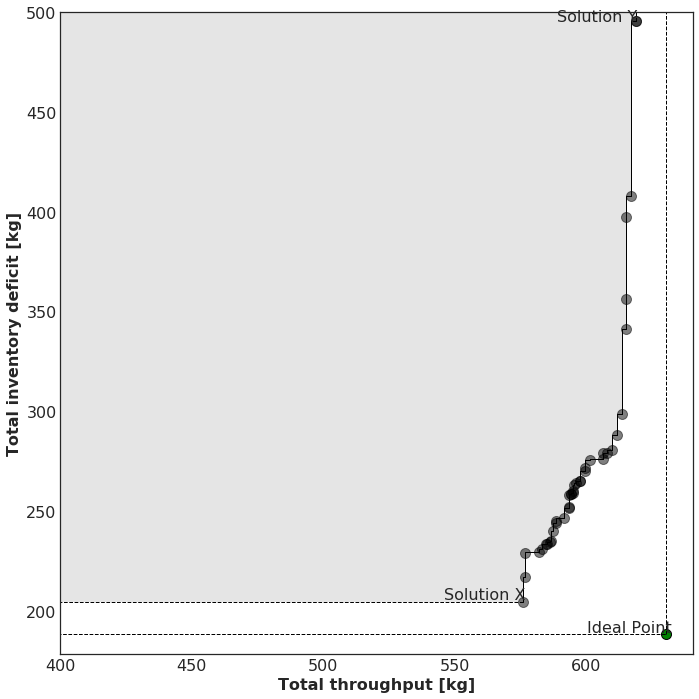

In [24]:
objective_x = 'total_kg_throughput'
objective_y = 'total_kg_inventory_deficit'

# Extract the values for each objective
x = [schedule.objectives[objective_x].values[0] for schedule in model3.schedules]
y = [schedule.objectives[objective_y].values[0] for schedule in model3.schedules]

# Reference point, worst possible values, for calculating the hypervolume
ref_point = [0, kg_inventory_target.sum().sum()]

# Ideal point is based on the best objective values achieved with single-objective GAs (model1 and model2) 
ideal_point = [
    model1.schedules[0].objectives[objective_x].values[0], 
    model2.schedules[0].objectives[objective_y].values[0], 
]

utils.plot_2D_pareto_front(
    x, 
    y, 
    'Total throughput [kg]',
    'Total inventory deficit [kg]',
    figsize=(10, 10),
    ref_point=ref_point,
    ideal_point=ideal_point,
    fillcolor='black',
    fillalpha=0.1
)

# Calculate raw hypervolume value
raw_hv = model3.score(
    model3.schedules,
    ref_point={
        objective_x: ref_point[0],
        objective_y: ref_point[1]
    }
)

# Calculate normalised hypervolume value (0.0 - 1.0)
norm_hv = model3.score(
    model3.schedules,
    ref_point={
        objective_x: ref_point[0],
        objective_y: ref_point[1]
    },
    ideal_point={
        objective_x: ideal_point[0],
        objective_y: ideal_point[1]        
    }
)

axes = plt.gca()
axes.set_xlim([400, 10 + max(max(x), ideal_point[0])])
axes.set_ylim([min(min(y), ideal_point[1]) - 10, 500])

# Mark the boundary solutions of the Pareto fron
plt.text(np.min(x) - 30, np.min(y) + 1, 'Solution X')
plt.text(np.max(x) - 30, np.max(y), 'Solution Y')

# Mark ideal point
plt.text(ideal_point[0] - 30, ideal_point[1] + 1, 'Ideal Point')

plt.tight_layout()
plt.show()

utils.display(utils.HTML('<h4/>Hypervolume: %.1f (%.4f)' % (raw_hv, norm_hv)))

### Solution X

Solution with the lowest ***total kg inventory deficit***.

value
total_backlog_penalty         0.0
total_cost                  780.4
total_inventory_penalty     204.6
total_kg_backlog              0.0
total_kg_inventory_deficit  204.6
total_kg_supply             449.8
total_kg_throughput         575.8
total_kg_waste                0.0
total_production_cost       575.8
total_profit               -330.6
total_revenue               449.8
total_storage_cost            0.0
total_waste_cost              0.0

Product  Batches     Kg       Start First Harvest First Batch  Last Batch
0        D        9   49.5  2016-12-01    2017-01-19  2017-01-26  2017-03-23
1        A       14   43.4  2017-02-24    2017-04-10  2017-04-17  2017-07-17
2        C        9   44.1  2017-06-18    2017-08-02  2017-08-09  2017-10-04
3        D       18   99.0  2017-09-05    2017-10-24  2017-10-31  2018-02-27
4        B        2   12.4  2018-02-01    2018-03-09  2018-03-20  2018-03-31
5        A       18   55.8  2018-03-02    2018-04-16  2018-04-23  2018-08-20
6        C       11   53.9  2018-07-22    2018-09-05  2018-09-12  2018-11-21
7        A        9   27.9  2018-10-23    2018-12-07  2018-12-14  2019-02-08
8        B        2   12.4  2019-01-13    2019-02-18  2019-03-01  2019-03-12
9        D       30  165.0  2019-02-11    2019-04-01  2019-04-08  2019-10-28
10       B        2   12.4  2019-10-02    2019-11-07  2019-11-18  2019-11-29

None

None

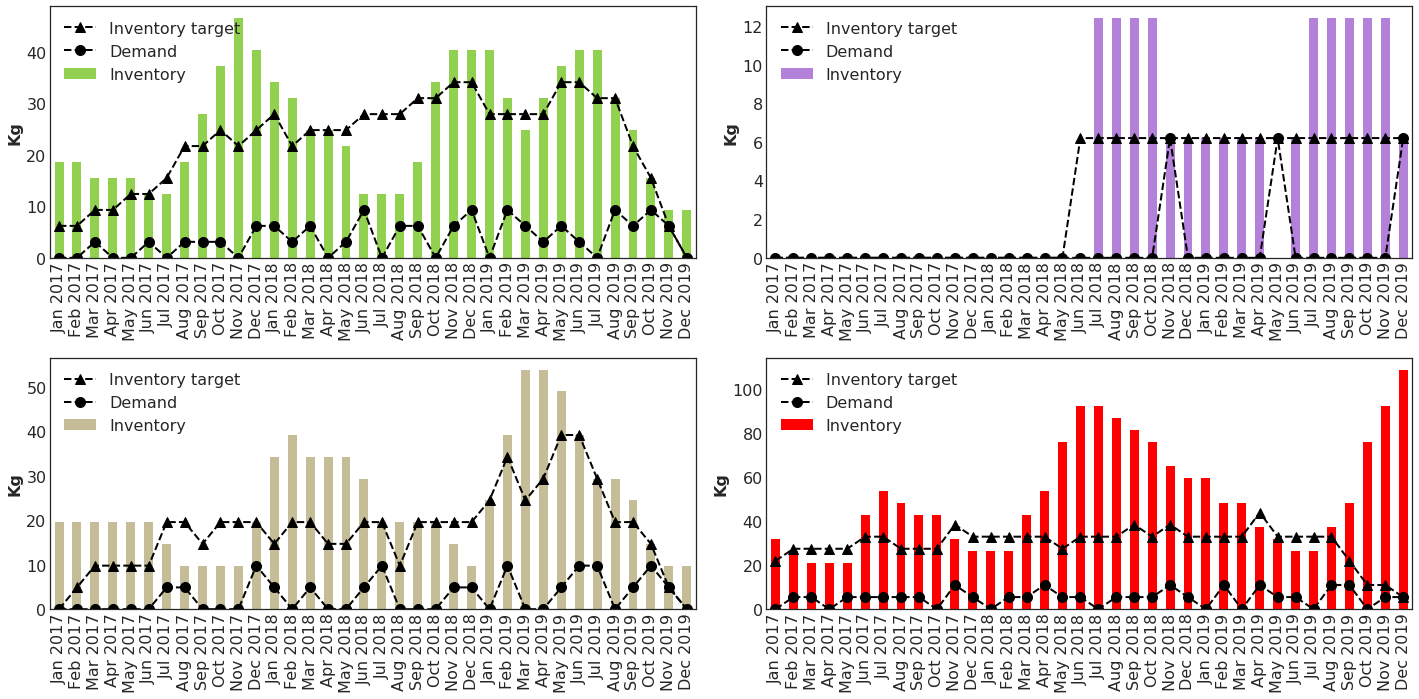

In [25]:
idx = np.argmin(y)

utils.show(model3.schedules[idx].objectives.transpose(), header='<h4>Objectives</h4>')
utils.show(model3.schedules[idx].campaigns, header='<h4>Campaigns table</h4>')

utils.display(utils.HTML('<h4>Gantt chart of campaigns</h4>'))
utils.display(model3.schedules[idx].campaigns_gantt(colors))

utils.display(utils.HTML('<h4>Gantt chart of tasks</h4>'))
utils.display(model3.schedules[idx].tasks_gantt(colors))

utils.display(utils.HTML('<h4>Inventory levels</h4>'))
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
xticks = [dt.strftime(d, '%b %Y') for d in pd.to_datetime(kg_demand.index)]
plt_colors = {
    'A': (146, 208, 80), 
    'B': (179, 129, 217), 
    'C': (196, 189, 151), 
    'D': (255, 0, 0)
}

for i in range(2):
    for j in range(2):
        p = kg_demand.columns[i * 2 + j]
        
        model3.schedules[idx].kg_inventory[[p]].plot(
            ax=ax[i][j],
            kind='bar', 
            color=tuple([x / 255 for x in plt_colors[p]]),
        )

        kg_inventory_target[[p]].plot(
            ax=ax[i][j],
            kind='line',
            color='black',
            linewidth=2,
            linestyle='--',
            marker='^',
            markersize=10,
        )
        
        kg_demand[[p]].plot(
            ax=ax[i][j],
            kind='line',
            color='black',
            linewidth=2,
            linestyle='--',
            marker='o',
            markersize=10,
        )

        ax[i][j].set_xticks(range(len(xticks)))
        ax[i][j].set_xticklabels(xticks, rotation='vertical')
        ax[i][j].legend(['Inventory target', 'Demand', 'Inventory'], loc='best')
        ax[i][j].set_xlabel('')
        ax[i][j].set_ylabel('Kg')
        
plt.tight_layout()
plt.show();

### Solution Y

value
total_backlog_penalty          0.0
total_cost                  1114.5
total_inventory_penalty      495.7
total_kg_backlog               0.0
total_kg_inventory_deficit   495.7
total_kg_supply              449.8
total_kg_throughput          618.8
total_kg_waste                 0.0
total_production_cost        618.8
total_profit                -664.7
total_revenue                449.8
total_storage_cost             0.0
total_waste_cost               0.0

Product  Batches     Kg       Start First Harvest First Batch  Last Batch
0       D       12   66.0  2016-12-01    2017-01-19  2017-01-26  2017-04-13
1       A       18   55.8  2017-03-17    2017-05-01  2017-05-08  2017-09-04
2       C       10   49.0  2017-08-06    2017-09-20  2017-09-27  2017-11-29
3       D       27  148.5  2017-10-31    2017-12-19  2017-12-26  2018-06-26
4       B        3   18.6  2018-05-31    2018-07-06  2018-07-17  2018-08-08
5       A       20   62.0  2018-07-10    2018-08-24  2018-08-31  2019-01-11
6       C       11   53.9  2018-12-13    2019-01-27  2019-02-03  2019-04-14
7       D       30  165.0  2019-03-16    2019-05-04  2019-05-11  2019-11-30

None

None

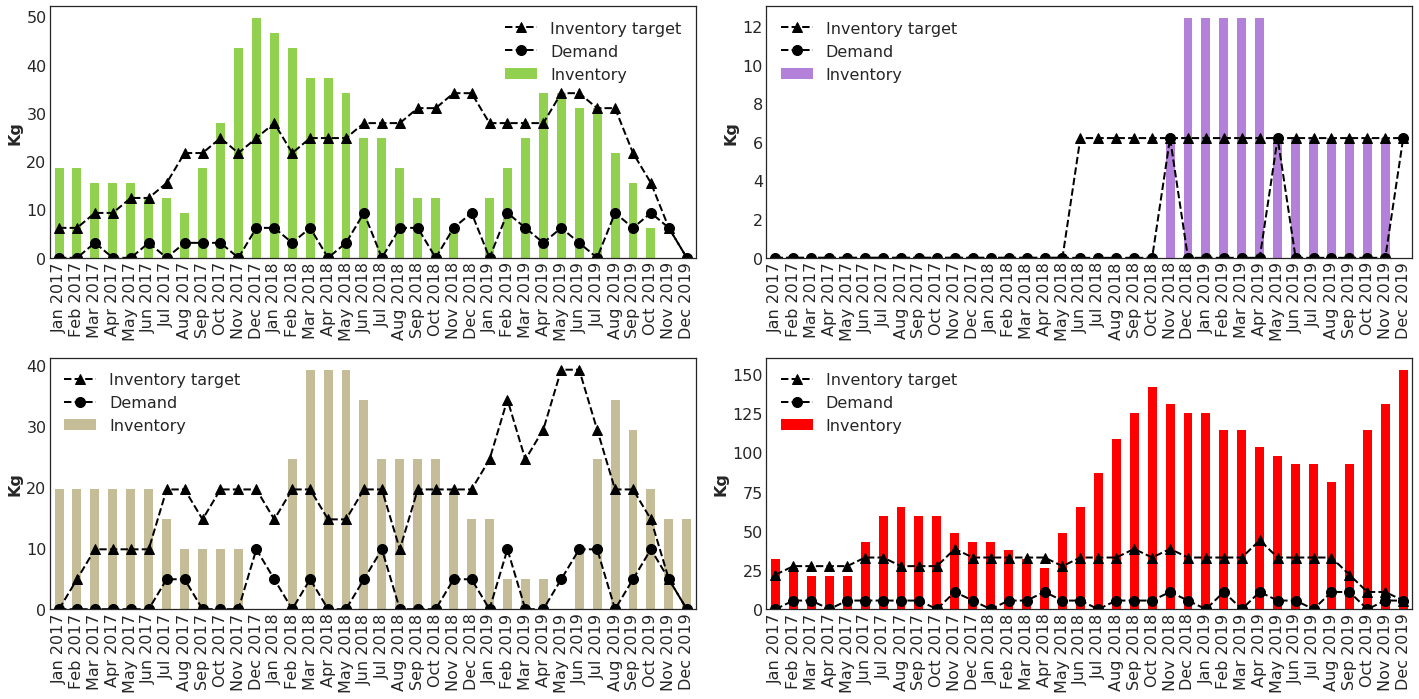

In [26]:
idx = np.argmax(x)

utils.show(model3.schedules[idx].objectives.transpose(), header='<h4>Objectives</h4>')
utils.show(model3.schedules[idx].campaigns, header='<h4>Campaigns table</h4>')

utils.display(utils.HTML('<h4>Gantt chart of campaigns</h4>'))
utils.display(model3.schedules[idx].campaigns_gantt(colors))

utils.display(utils.HTML('<h4>Gantt chart of tasks</h4>'))
utils.display(model3.schedules[idx].tasks_gantt(colors))

utils.display(utils.HTML('<h4>Inventory levels</h4>'))
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
xticks = [dt.strftime(d, '%b %Y') for d in pd.to_datetime(kg_demand.index)]
plt_colors = {
    'A': (146, 208, 80), 
    'B': (179, 129, 217), 
    'C': (196, 189, 151), 
    'D': (255, 0, 0)
}

for i in range(2):
    for j in range(2):
        p = kg_demand.columns[i * 2 + j]
        
        model3.schedules[idx].kg_inventory[[p]].plot(
            ax=ax[i][j],
            kind='bar', 
            color=tuple([x / 255 for x in plt_colors[p]]),
        )

        kg_inventory_target[[p]].plot(
            ax=ax[i][j],
            kind='line',
            color='black',
            linewidth=2,
            linestyle='--',
            marker='^',
            markersize=10,
        )
        
        kg_demand[[p]].plot(
            ax=ax[i][j],
            kind='line',
            color='black',
            linewidth=2,
            linestyle='--',
            marker='o',
            markersize=10,
        )

        ax[i][j].set_xticks(range(len(xticks)))
        ax[i][j].set_xticklabels(xticks, rotation='vertical')
        ax[i][j].legend(['Inventory target', 'Demand', 'Inventory'], loc='best')
        ax[i][j].set_xlabel('')
        ax[i][j].set_ylabel('Kg')
        
plt.tight_layout()
plt.show();

[back to index](#index)